# Analyzing COVID-19 data

The notebook below has been created in a hurry, no guarantee at all. Doublecheck all computations etc. before 

The data is dynamically imported from https://raw.githubusercontent.com/CSSEGISandData

Read their terms of use! Last time I checked it, it is strictly for public use in academic or research purposes.

## Import data

In [142]:
import pandas as pd
import numpy as np

# raw_types = [ "Confirmed", "Recovered", "Deaths" ]
raw_types = [ "Confirmed", "Deaths" ]

raw_urls = {}
raw_urls["Confirmed"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
# Deprecated: raw_urls["Recovered"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
raw_urls["Deaths"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

raw_df = {}
for raw_type in raw_types:
    raw_df[raw_type] = pd.read_csv(raw_urls[raw_type])
    

Let's have a look which province/states and countries/regions are included. Only a part of the list is shown.

In [143]:
raw_df[raw_types[0]][~pd.notnull(raw_df[raw_types[0]]['Province/State'])]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,3,3
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,45,56,68,79,97,128,158,266,301,387
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,26,52,78,84,115,136,160,194,235,249
16,NaN,Austria,47.516200,14.550100,0,0,0,0,0,0,...,860,1018,1332,1646,2013,2388,2814,3582,4474,5283
17,NaN,Azerbaijan,40.143100,47.576900,0,0,0,0,0,0,...,23,28,28,28,44,44,53,65,72,87


# Adaptation

Via the following list you can adapt which countries to be analyzed. 

Note: For some countries (e.g. China, United States), the input data is further decomposed into provinces/states. Only some of these countries are supported, see below.

In [144]:
countries = [ 'Germany', 'Italy', 'India', 'Austria', 'Spain', 'US', 'United Kingdom' ]

Check that all countries have accociated data.

In [145]:
remove_states = raw_df[raw_types[0]][~pd.notnull(raw_df[raw_types[0]]['Province/State'])]
for country in countries:    
    filtered = remove_states.loc[remove_states['Country/Region'].eq(country)]
    if (filtered.empty):
        raise ValueError("Country "+country+" not found in input data.")           

Special treatment of specific countries which are decomposed into provinces/states.

In [146]:
raw_df[raw_types[0]]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,3,3
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,45,56,68,79,97,128,158,266,301,387
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,26,52,78,84,115,136,160,194,235,249
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,1,2,2,3,4,6,9,19,32,39
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,134,171,210,267,307,353,436,669,669,818


In [147]:
decomposed_countries = {}

# Not required anymore, US now appears as sum as well
# Use first 52 entries as list of states in US
#us_states = raw_df[raw_types[0]][raw_df[raw_types[0]]['Country/Region']=='US'][:52]
#decomposed_countries['US'] = us_states['Province/State'].tolist()

# decomposed_countries['US']
#uk_states = raw_df[raw_types[0]][raw_df[raw_types[0]]['Country/Region']=='United Kingdom']
#decomposed_countries['United Kingdom'] = uk_states['Province/State'].tolist()


## Convert Data

In [148]:
def extract_values(df, country):
    filtered = df[~pd.notnull(df['Province/State']) & df['Country/Region'].eq(country)]
    transposed = filtered.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose()
    values = transposed[transposed.columns[0]]
    return values

dates = raw_df[raw_types[0]].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose().index.tolist()

# Get data for countries
all = {}
for country in countries:
    data = {}
    for raw_type in raw_types:
        values = extract_values(raw_df[raw_type], country)
        data[raw_type] = values
    all[country] = pd.DataFrame(data, index=dates)

In [149]:
def extract_values_with_region(df, country, region):
    filtered = df[df['Province/State'].eq(region) & df['Country/Region'].eq(country)]
    transposed = filtered.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose()
    values = transposed[transposed.columns[0]]
    return values

dates = raw_df[raw_types[0]].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose().index.tolist()
ext_countries = countries

# Get data for states/regions with associated countries
for dcountry in decomposed_countries:
    sub = {}
    df1 = pd.DataFrame(data=0, index=dates, columns=raw_types)            
    first = True
    for region in decomposed_countries[dcountry]:
        data = {}
        for raw_type in raw_types:
            values = extract_values_with_region(raw_df[raw_type], dcountry, region)            
            df1[raw_type] = df1[raw_type] + values 
    all[dcountry] = df1
    ext_countries.append(dcountry)
    
all["US"].tail(15)

,Confirmed,Deaths
3/10/20,959,28
3/11/20,1281,36
3/12/20,1663,40
3/13/20,2179,47
3/14/20,2727,54
3/15/20,3499,63
3/16/20,4632,85
3/17/20,6421,108
3/18/20,7783,118
3/19/20,13677,200


Show intermediate data.

## Enrich data

Enrich by computing Active = Confirmed - (Recovered + Deaths)

In [150]:
for country in ext_countries:
    # Underlying data sets doesn't support RECOVERED anymore
    #all[country]["Active"] = all[country]["Confirmed"] - (all[country]["Recovered"] + all[country]["Deaths"])
    all[country]["Active"] = all[country]["Confirmed"] - (all[country]["Deaths"])

raw_types_ext = raw_types.copy()
raw_types_ext.append("Active")

Enrich by computing the rate and moving average on rate.

In [151]:
window_size = 7

def addRate(df, label):
    df[label+" Rate"] = df[label].pct_change().replace(np.inf,0)
    
def addMovAverage(df, label, window_size):
    df[label+" Avg"] = df[label].rolling(window=window_size,center=False).mean()    
    #df[label+" Avg"] = df[label].ewm(com=0.1).mean()   

def addInterpolate(df, label):
    df[label+" Avg"] = df[label].interpolate(method='linear', axis=0)
                       
for country in ext_countries:
    for raw_type in raw_types_ext:
        addRate(all[country], raw_type)
        addMovAverage(all[country], raw_type+" Rate", window_size)
        #addInterpolate(all[country], raw_type+" Rate")

# Prediction

In [152]:
preview = 7

def predict(input_df, dimension):
    for raw_type in raw_types_ext:
        rate = input_df[dimension + " Rate Avg"]
        #diff = all[country]["Deaths Rate Avg"] - all[country]["Deaths Rate Avg"].shift(1)
        predict = input_df[dimension]
        for outlook in range(1,preview):
            predict = predict * (1+rate*0.9)
        input_df[dimension+" Predict"] = predict

for country in ext_countries:
    predict(all[country], "Confirmed")
    predict(all[country], "Deaths")


Show part of final data.

In [153]:
all["US"].tail(15)

,Confirmed,Deaths,Active,Confirmed Rate,Confirmed Rate Avg,Deaths Rate,Deaths Rate Avg,Active Rate,Active Rate Avg,Confirmed Predict,Deaths Predict
3/10/20,959,28,931,0.644940,0.359970,0.272727,0.228419,0.659537,0.367163,5165.279964,85.966109
3/11/20,1281,36,1245,0.335766,0.370407,0.285714,0.187602,0.337272,0.380596,7198.555280,91.798913
3/12/20,1663,40,1623,0.298205,0.347811,0.111111,0.190488,0.303614,0.354611,8521.959741,103.366341
3/13/20,2179,47,2132,0.310283,0.362512,0.175000,0.191679,0.313617,0.369449,11858.532910,122.123494
3/14/20,2727,54,2673,0.251492,0.322104,0.148936,0.182343,0.253752,0.326782,12560.521096,134.386381
3/15/20,3499,63,3436,0.283095,0.321323,0.166667,0.172539,0.285447,0.326002,16063.765470,149.787659
3/16/20,4632,85,4547,0.323807,0.349655,0.349206,0.215623,0.323341,0.353797,23917.081445,246.364197
3/17/20,6421,108,6313,0.386226,0.312696,0.270588,0.215318,0.388388,0.315062,28429.221257,312.595116
3/18/20,7783,118,7665,0.212116,0.295032,0.092593,0.187729,0.214161,0.297474,31972.677849,301.072216
3/19/20,13677,200,13477,0.757292,0.360616,0.694915,0.271129,0.758252,0.362423,73859.980116,741.287390


## Plot data

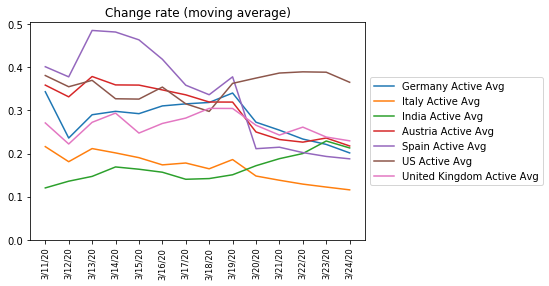

In [154]:
import matplotlib.pyplot as plt

number_of_days = 14

for country in ext_countries:
    ts = all[country]["Active Rate Avg"].tail(number_of_days)
    pl = ts.plot(label=country+" Active Avg")
    
    # Uncomment the following to add all lines in one figure
    #cl = plt.gca().lines[-1].get_color()    
    #ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    #ts.plot(label=country+" Deaths", linestyle='dashed', color=cl)

plt.title("Change rate (moving average)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
# Set maximum y-value 
axes = plt.gca()
axes.set_ylim([0,min(axes.get_ylim()[1],1.0)])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


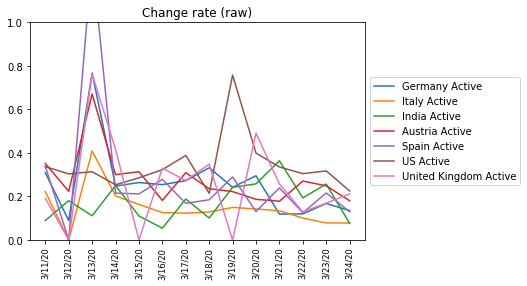

In [155]:
import matplotlib.pyplot as plt

number_of_days = 14

for country in ext_countries:
    ts = all[country]["Active Rate"].tail(number_of_days)
    pl = ts.plot(label=country+" Active")
    
    # Uncomment the following to add all lines in one figure
    #cl = plt.gca().lines[-1].get_color()    
    #ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    #ts.plot(label=country+" Deaths", linestyle='dashed', color=cl)

plt.title("Change rate (raw)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
# Set maximum y-value 
axes = plt.gca()
axes.set_ylim([0,min(axes.get_ylim()[1],1.0)])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The y-axis shows the daily growth in percentage, e.g. 0.4 means that 40% more cases have been reported.

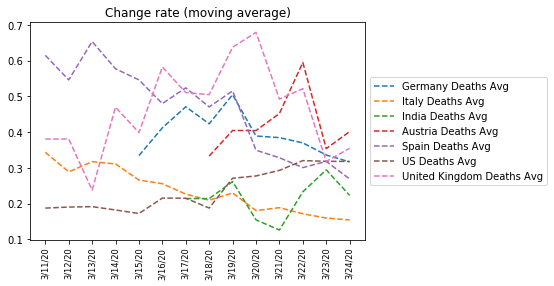

In [156]:
for country in ext_countries:
    ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    ts.plot(label=country+" Deaths Avg", linestyle='dashed')
        
plt.title("Change rate (moving average)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

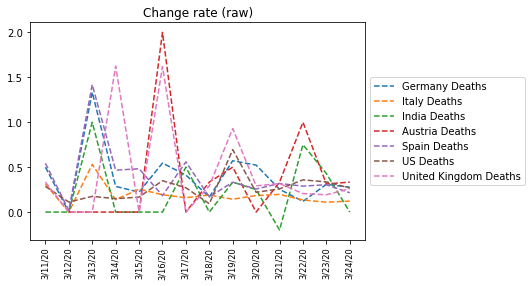

In [157]:
for country in ext_countries:
    ts = all[country]["Deaths Rate"].tail(number_of_days)
    ts.plot(label=country+" Deaths", linestyle='dashed')
       
plt.title("Change rate (raw)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Diagram per Country

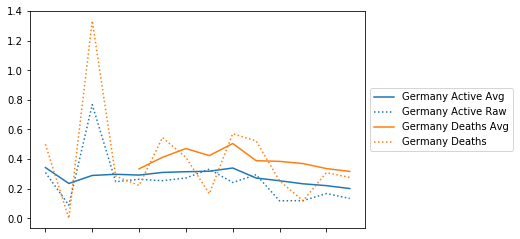

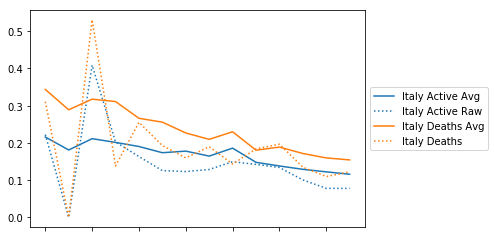

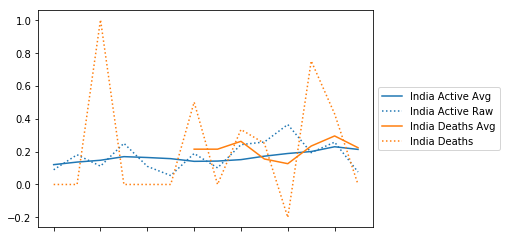

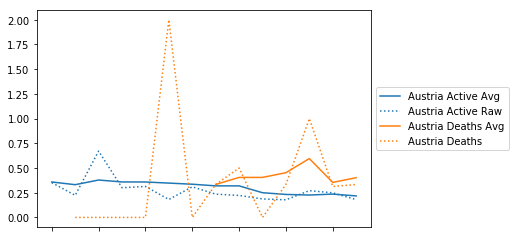

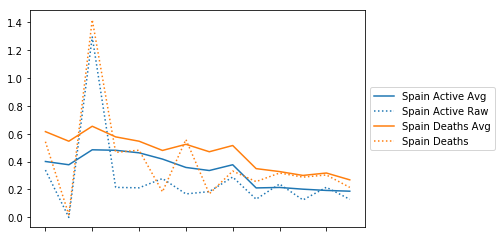

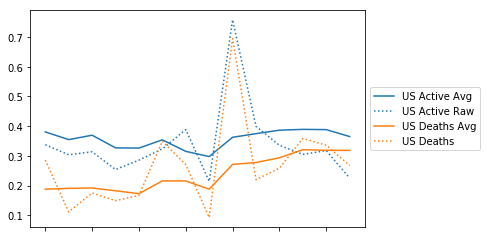

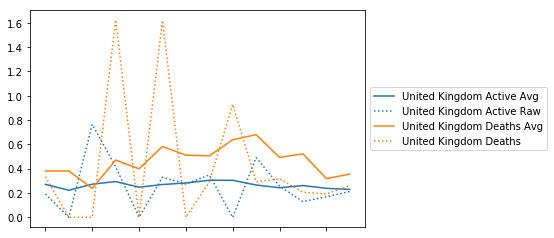

In [164]:
for country in ext_countries:
    ts = all[country]["Active Rate Avg"].tail(number_of_days)
    pl = ts.plot(label=country+" Active Avg")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Active Rate"].tail(number_of_days)
    ts.plot(label=country+" Active Raw", linestyle='dotted', color=cl)

    ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    pl = ts.plot(label=country+" Deaths Avg")
    
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Deaths Rate"].tail(number_of_days)
    ts.plot(label=country+" Deaths", linestyle='dotted', color=cl)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

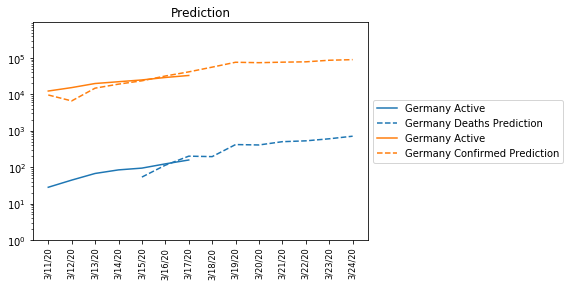

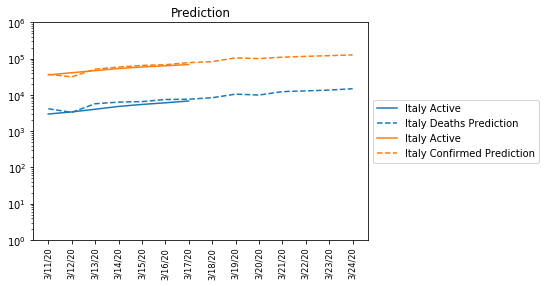

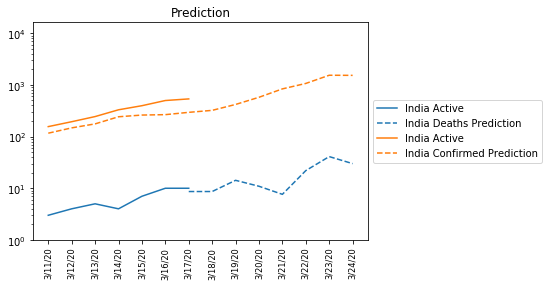

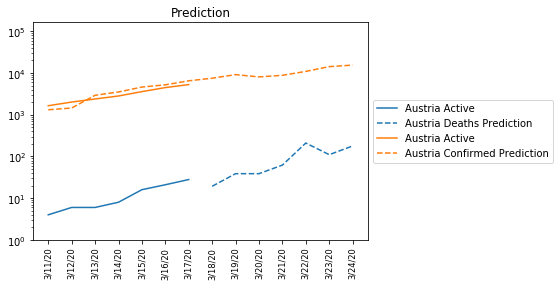

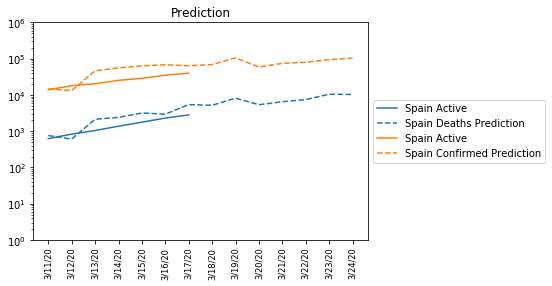

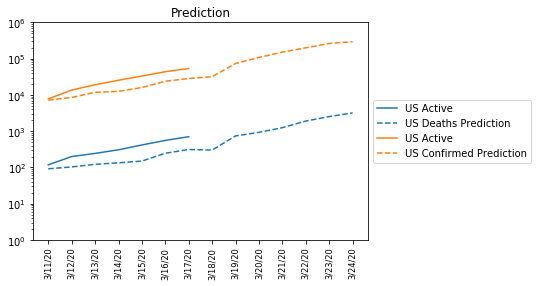

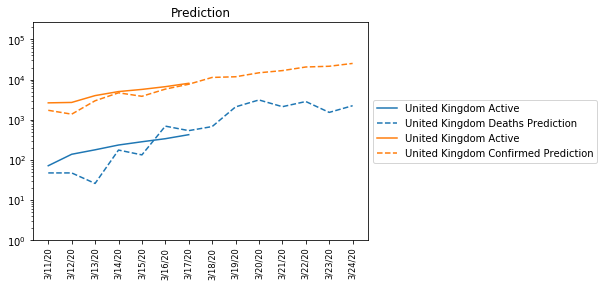

In [175]:
for country in ext_countries:
    ts = all[country]["Deaths"].shift(-preview).tail(number_of_days)
    pl = ts.plot(label=country+" Active")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Deaths Predict"].tail(number_of_days)
    ts.plot(label=country+" Deaths Prediction", linestyle='dashed', color=cl)

    ts = all[country]["Confirmed"].shift(-preview).tail(number_of_days)
    pl = ts.plot(label=country+" Active")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Confirmed Predict"].tail(number_of_days)
    
    ts.plot(label=country+" Confirmed Prediction", linestyle='dashed', color=cl)

    plt.title("Prediction")
    plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
               fontsize='small', rotation='vertical')

    # Set maximum y-value 
    axes = plt.gca()
    axes.set_ylim([0,min(axes.get_ylim()[1],100000)])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes = plt.gca()
    axes.set_ylim([1,min(max(10,10*axes.get_ylim()[1]),1000000)])
    axes.set_yscale("log")
    
    plt.show()

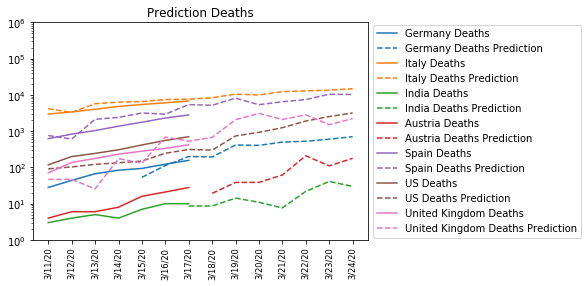

In [171]:
for country in ext_countries:
    ts = all[country]["Deaths"].shift(-preview).tail(number_of_days)
    pl = ts.plot(label=country+" Deaths")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Deaths Predict"].tail(number_of_days)
    
    axes = plt.gca()
    axes.set_ylim([1,min(10*axes.get_ylim()[1],1000000)])
    axes.set_yscale("log")
    
    ts.plot(label=country+" Deaths Prediction", linestyle='dashed', color=cl)

    plt.title("Prediction Deaths")
    plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
               fontsize='small', rotation='vertical')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

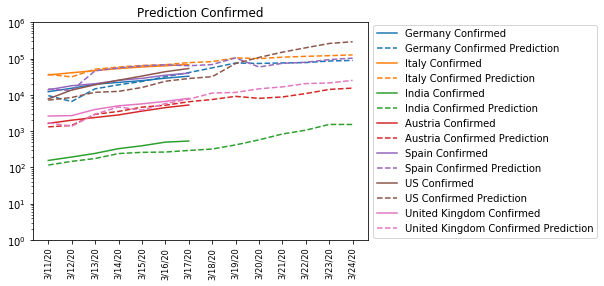

In [170]:
for country in ext_countries:
    ts = all[country]["Confirmed"].shift(-preview).tail(number_of_days)
    pl = ts.plot(label=country+" Confirmed")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Confirmed Predict"].tail(number_of_days)
    ts.plot(label=country+" Confirmed Prediction", linestyle='dashed', color=cl)

    plt.title("Prediction Confirmed")
    plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
               fontsize='small', rotation='vertical')

    # Set maximum y-value 
    axes = plt.gca()
    axes.set_ylim([1,min(10*axes.get_ylim()[1],1000000)])
    axes.set_yscale("log")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()